In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
from pathlib import Path
import json
from datetime import datetime
from tqdm import tqdm
import numpy as np
from PIL import Image
import lovely_tensors as lt
lt.monkey_patch()
import torch

from hmr4d.dataset.pure_motion.amass import AmassDataset
from hmr4d.dataset.pure_motion.cam_traj_utils_v2 import create_rotation_track, create_translation_track
from hmr4d.utils.body_model import BodyModelSMPLX
from hmr4d.utils.body_model.utils import load_hand_faces_and_colors
from hmr4d.utils.geo_transform import transform_mat
from hmr4d.utils.geo.transforms import axis_rotate_to_matrix
from hmr4d.utils.vis.renderer import Renderer, Renderer_Point
from hmr4d.utils.video_io_utils import get_writer
from hmr4d.utils.image_gen.stable_diffusion import ImageGenerator
import third_party.depth_pro.depth_pro as depth_pro
from third_party.depth_pro.utils import get_boundaries_mask, get_depth_image, get_points_3d

device = 'cuda:0'

/home/guangyu/anaconda3/envs/hmr/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/home/guangyu/anaconda3/envs/hmr/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/guangyu/anaconda3/envs/hmr/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  wa

In [2]:
width, height = 768, 480

dataset = AmassDataset(cam_augmentation='v20', width=width, height=height, f_fullframe=24.0, 
                       motion_frames=120)

smplx = BodyModelSMPLX(
    model_path="inputs/checkpoints/body_models", model_type="smplx",
    gender="neutral", num_pca_comps=12, flat_hand_mean=False,
).to(device)
smplx_colors = torch.tensor(torch.load("hmr4d/utils/body_model/smplx_color.pt")/ 255.)[None]

hand_idxs, hand_faces, hand_colors = load_hand_faces_and_colors(smplx.faces)
hand_faces = hand_faces.to(device)

/home/guangyu/patrick/GVHMR/hmr4d/utils/body_model/smplx_lite.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smplx2smpl = torch.load(PROJ_ROOT / "hmr4d/utils/body_mod

In [ ]:
img_gen = ImageGenerator(device=device)
depth_model, depth_transform = depth_pro.create_model_and_transforms(device=device)
depth_model = depth_model.eval()

In [4]:
id_prompts = [
    # Male / Unknown
    "A young man with short, slightly wavy hair and light stubble, wearing a fitted beige jacket over a white t-shirt and dark denim jeans, stands confidently, exuding a casual yet expressive gesture. ", 
    # Female / Unknown
    "A young woman with shoulder-length straight hair parted naturally, wearing a fitted neutral-toned blazer over a simple white top and tailored pants, stands upright with a relaxed yet confident posture. ",
    # Male / Middle Eastern
    "A Middle Eastern man in his early thirties with neatly trimmed dark hair and a short beard, dressed in a charcoal wool coat over a dark turtleneck and slim-fit trousers, leans slightly forward with one hand in his pocket, giving a thoughtful, composed presence. ",
    # Female / Black (African descent)
    "A tall Black woman with deep brown skin and natural textured hair styled in a high puff, wearing a modern sleeveless jumpsuit in muted earth tones, stands upright with squared shoulders, projecting strength and elegance. ",
    # Male / White (European descent)
    "A Caucasian man with medium-length tousled blond hair and a clean-shaven face, wearing a relaxed linen shirt with rolled-up sleeves and light chinos, stands casually with a slight hip shift, conveying an effortless, laid-back charm. ", 
    # Female / Latina
    "A Latina woman with shoulder-length wavy dark hair and warm olive skin, dressed in a fitted leather jacket over a soft knit top and high-waisted jeans, stands with crossed arms and a subtle smile, radiating confidence and edge. ",
    # Male / South Asian
    "A South Asian man with neatly combed hair and light stubble, wearing a tailored navy blazer over a crisp white shirt and dark slacks, stands straight with his hands at his sides, presenting a polished and professional demeanor. ",
    # Female / Mixed Ethnicity
    "A mixed-ethnicity woman with short, curly hair dyed deep auburn, wearing an oversized knit sweater and pleated skirt in neutral tones, stands slightly angled with relaxed shoulders, giving an artistic and introspective feel. ",
    # Male / East Asian
    "An East Asian man with straight jet-black hair parted cleanly to the side, wearing a long tailored coat over a monochrome outfit, stands upright with a composed posture and neutral expression, embodying modern urban sophistication. ",
    # Female / East Asian
    "A young East Asian woman with long, straight black hair tied in a low ponytail, wearing a minimalist black blazer over a silk ivory blouse and tailored trousers, stands calmly with her hands loosely clasped, exuding quiet confidence. ", 
]

scene_prompts = [
    # Modern city square
    "The scene takes place in a modern city square paved with smooth stone tiles, surrounded by contemporary glass-and-steel office buildings that reflect the warm afternoon sunlight.", 
    # Indoor architectural lobby
    "The scene takes place inside a spacious modern lobby with polished concrete floors, tall ceilings, and floor-to-ceiling windows that allow natural light to softly fill the space.",
    # Urban park edge
    "The scene is set at the edge of a well-maintained urban park, featuring trimmed greenery, paved walkways, and contemporary buildings visible in the background under clear daylight.",
    # Rooftop terrace
    "The scene takes place on a modern rooftop terrace with glass railings, subtle greenery, and a distant city skyline visible beneath a bright, open sky.",
    # Minimalist indoor studio
    "The scene is set in a minimalist indoor studio with smooth neutral-colored walls, soft diffused lighting, and a clean, uncluttered atmosphere.",
    # Open natural landscape
    "The scene takes place in an open natural landscape with gently rolling terrain, low vegetation, and a broad, unobstructed ground plane, extending toward distant hills beneath a wide, softly lit sky.",
    # Coastal environment
    "The scene is set along a quiet coastline featuring a wide stretch of firm sand, calm ocean waves, and an open horizon, illuminated by soft, even daylight.",
    # Mountain overlook
    "The scene unfolds at a spacious mountain overlook with flat rock surfaces, expansive views of layered ridgelines, and clear natural lighting that emphasizes the open surroundings.",
    # Industrial interior
    "The scene is set inside a converted industrial warehouse with wide open floors, high ceilings, exposed concrete and steel elements, and evenly diffused lighting across the space.",
    # Countryside road
    "The scene takes place along a quiet countryside road with a broad, empty surface and open surroundings, bordered by low vegetation and stretching freely toward the horizon."
]

In [121]:
output_path = Path("outputs/uni3c_aligned/test_" + datetime.strftime(datetime.now(), "%m%d%H%M%S"))
output_path.mkdir(parents=True, exist_ok=True)

tensor[120, 127, 3] n=45720 (0.2Mb) x∈[-0.387, 1.825] μ=1.023 σ=0.467
Percentage : 0.39%
Percentage : 0.45%
Percentage : 0.48%
Head looking backwards camera: tensor[1] bool [True] (0.09)
Backward facing detected (z=0.09), flip camera
Head looking backwards camera: tensor[1] bool [True] (0.60)
Margin adjusting: (230.92, 89.17, 273.69, 131.07) dx_px=0.0, dy_px=150.8
Margin adjusting: (230.92, 236.92, 273.69, 277.31) dx_px=0.0, dy_px=3.1
Margin adjusting: (230.92, 239.94, 273.69, 280.29) dx_px=0.0, dy_px=0.1
Camera rotation deltas (yaw, pitch, roll): (3.2, 3.4, -2.0)
Camera translation deltas (tx, ty, tz): (-0.19, -0.18, -0.25)


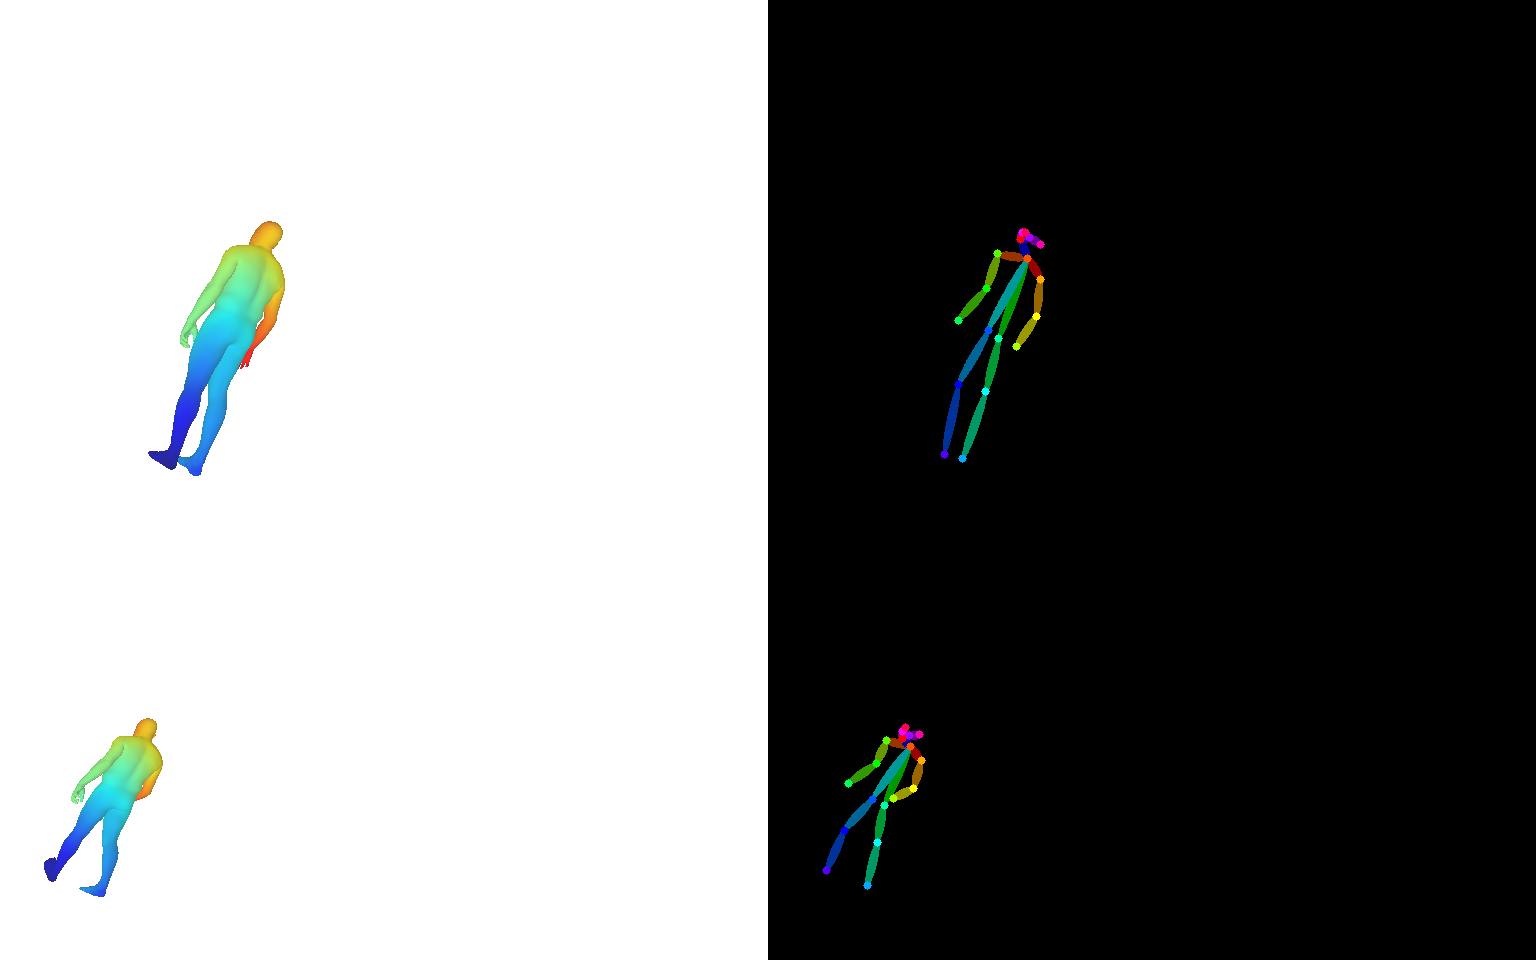

In [122]:
index = np.random.randint(len(dataset))

batch = dataset[index]
nframe = batch["length"]
K_fullimg = batch['K_fullimg'][0]
smpl_params_c = batch['smpl_params_c']
batch['index'] = index
torch.save(batch, output_path / "batch_meta.pt")

verts = smplx(**{k:v.to(device) for k,v in smpl_params_c.items()}).vertices
joints = smplx(**{k:v.to(device) for k,v in smpl_params_c.items()}).joints

renderer_c = Renderer(width, height, device="cuda", faces=smplx.faces, K=K_fullimg)

pred_c_joints, pred_c_valids = renderer_c.project_points_to_full_image(joints[0])
canvas_1 = renderer_c.render_openpose(pred_c_joints, pred_c_valids)
smpl_rgbs_1 = renderer_c.render_mesh(verts[0], colors=smplx_colors)
pred_c_joints, pred_c_valids = renderer_c.project_points_to_full_image(joints[-1])
canvas_2 = renderer_c.render_openpose(pred_c_joints, pred_c_valids)
smpl_rgbs_2 = renderer_c.render_mesh(verts[-1], colors=smplx_colors)
total_img = Image.fromarray(np.concatenate([
    np.concatenate([smpl_rgbs_1, canvas_1], axis=1),
    np.concatenate([smpl_rgbs_2, canvas_2], axis=1),
], axis=0))

total_img

In [123]:
renderer_c = Renderer(width, height, device="cuda", faces=smplx.faces, K=K_fullimg)

writer1 = get_writer(output_path / 'smpl_render.mp4', fps=30, crf=23)
writer2 = get_writer(output_path / 'hand_render.mp4', fps=30, crf=23)
for j in tqdm(range(nframe), desc=f"Rendering Global"):
    black_backg = np.zeros((height, width, 3)).astype(np.uint8)
    smpl_rgbs, smpl_depths = renderer_c.render_mesh(
        verts[j], background=black_backg, 
        colors=smplx_colors, return_depth=True
    )
    hand_rgbs, hand_depths = renderer_c.render_mesh(
        verts[j, hand_idxs], background=black_backg, faces=hand_faces,
        colors=hand_colors,  return_depth=True
    )
    unify_mask = (hand_depths <= smpl_depths+0.01)[..., None]

    refined_hand_rgbs = np.clip(
        hand_rgbs * unify_mask + np.zeros_like(hand_rgbs) * (1 - unify_mask), 
    0, 255).astype(np.uint8)

    writer1.write_frame(smpl_rgbs)
    writer2.write_frame(refined_hand_rgbs)
writer1.close()
writer2.close()

pred_c_joints, pred_c_valids = renderer_c.project_points_to_full_image(joints[0])
canvas = renderer_c.render_openpose(pred_c_joints, pred_c_valids)

Rendering Global: 100%|██████████| 120/120 [00:04<00:00, 26.91it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

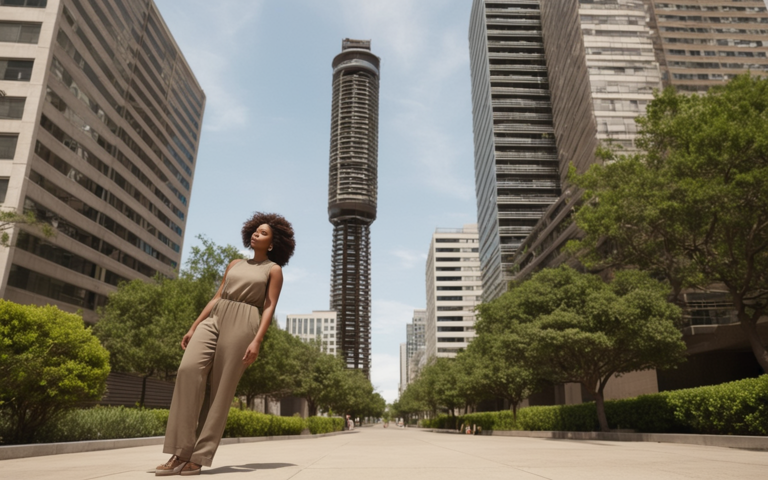

In [124]:
prompt = np.random.choice(id_prompts) + np.random.choice(scene_prompts) 
seed = np.random.randint(2**31)
coarse_img, coarse_meta = img_gen.step1(
    prompt=prompt,
    image=Image.fromarray(canvas),
    width=width, height=height, 
    generator = torch.Generator(device='cuda').manual_seed(seed)
)

final_img, final_meta = img_gen.step2(
    prompt=prompt,
    image=coarse_img[0],
    width=width*2, height=height*2,
    generator = torch.Generator(device='cuda').manual_seed(seed)

)
coarse_img[0].save(output_path / "reference_coarse.png")
final_img = final_img[0].resize((width, height))
final_img.save(output_path / "reference.png")
(output_path / "img_meta.json").write_text(json.dumps({'coarse_meta': coarse_meta, 'final_meta': final_meta}, indent=4))
final_img

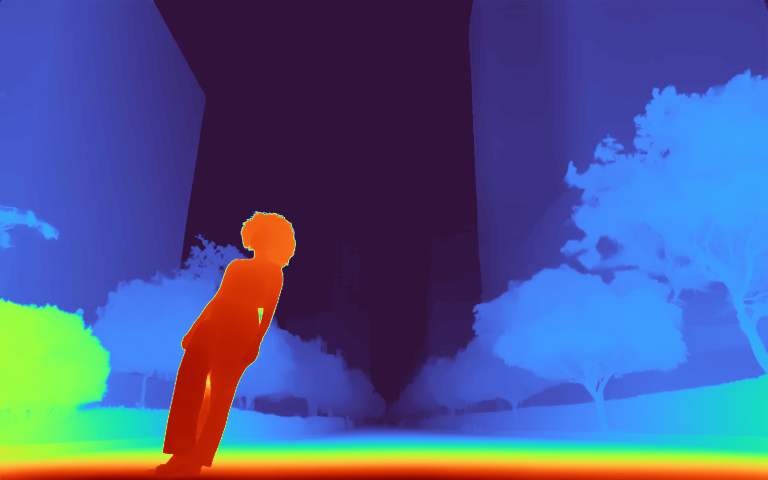

In [125]:
prediction = depth_model.infer(depth_transform(np.array(final_img)), f_px=K_fullimg[0,0].to(device))
depth = torch.clip(prediction["depth"], 1e-4, 100)  # Depth in [m].

key_3d_index = (pred_c_joints[0,:,1] * width + pred_c_joints[0,:, 0]).numpy().astype(int)
key_3d_index = key_3d_index[pred_c_valids[0].numpy().astype(bool)]
depth_avg = depth.reshape(-1)[key_3d_index].median().item()

boundary_mask = get_boundaries_mask((1 / (depth + 1e-7))[None, None], sobel_threshold=0.35)[0, 0].reshape(-1).cpu()

color_depth = get_depth_image(depth.detach().cpu().numpy(), min_depth=0.1, max_depth=250.0)
color_depth.save(output_path / "depth.png")
color_depth

In [126]:
start_elevation = 5.0

points3d = get_points_3d(depth, K_fullimg)
c2w_0 = torch.eye(4)
c2w_0[2, 3] = -depth_avg
R_elevation = axis_rotate_to_matrix(-start_elevation, 'x', with_trans=True, use_deg=True)[0]
c2w_0 = R_elevation @ c2w_0
points3d = (c2w_0.numpy()[:3] @ points3d.T).T
colors = np.array(final_img).reshape(height * width, 3) / 255.

c2ws = c2w_0.clone()
R_tmp = c2ws[:3,:3]
R_tmp[:, 0] = -R_tmp[:, 0]
R_tmp[:, 1] = -R_tmp[:, 1]
T_tmp = c2ws.inverse()[:3, -1]

R_w2c_tmp, _1 = create_rotation_track(R_tmp, nframe, linspace=batch['meta']['R_linspace'], **{k : batch['meta']['cam_meta'][k] for k in ['yaw', 'pitch', 'roll']})
t_w2c_tmp, _2 = create_translation_track(R_tmp, T_tmp, nframe, linspace=batch['meta']['t_linspace'], **{k : batch['meta']['cam_meta'][k] for k in ['tx', 'ty', 'tz']})
T_w2c_tmp = transform_mat(R_w2c_tmp, t_w2c_tmp)

cam_info = {
    "intrinsic": K_fullimg.numpy().tolist(), 
    "extrinsic": T_w2c_tmp.numpy().tolist(), 
    "height": height, "width": width
}
Path(output_path / "cam_info.json").write_text(json.dumps(cam_info))

34179

In [127]:
renderer_pc = Renderer_Point(width, height, K_fullimg, device=device)
point_cloud = renderer_pc.create_point_cloud(points3d, colors, boundary_mask=boundary_mask)

writer1 = get_writer(output_path / 'render.mp4', fps=30, crf=23)
writer2 = get_writer(output_path / 'render_mask.mp4', fps=30, crf=23)
writer3 = get_writer(output_path / 'combined_render.mp4', fps=30, crf=23)

for j in tqdm(range(nframe), desc=f"Rendering Global"):
    camera = renderer_pc.create_camera(T_w2c_tmp[j:j+1].to(device))
    render_rgb, render_mask = renderer_pc(point_cloud, camera)
    
    render_smpl_rgbs, render_smpl_masks = renderer_c.render_mesh(
        verts[j], background=np.zeros((height, width, 3)).astype(np.uint8), 
        colors=smplx_colors,
        return_mask=True
    )
    render_fused_smpl_rgbs = np.clip(
        render_smpl_rgbs * render_smpl_masks + render_rgb * (1 - render_smpl_masks), 
    0, 255).astype(np.uint8)

    writer1.write_frame(render_rgb)
    writer2.write_frame(render_mask)
    writer3.write_frame(render_fused_smpl_rgbs)

writer1.close()
writer2.close()
writer3.close()

Rendering Global:   0%|          | 0/120 [00:00<?, ?it/s]

Rendering Global: 100%|██████████| 120/120 [00:10<00:00, 11.41it/s]


In [128]:
# motion_files = torch.load("inputs/AMASS/hmr4d_support/smplxpose_v2.pth")
# seqs = {k: v for k,v in motion_files.items() if 'moyo_smplxn' not in k and v['pose'].shape[0] >= 25}
# print(f"Total motion files: {len(seqs):,}")

# ### AMASS Train Dataset --Load Data-- ###
# key = 'inputs/smplx_amass/smplxn_raw/Transitions/Transitions/mazen_c3d/sit_jumpinplace_stageii.npz'
# start, end = 92, 212
# raw_data = seqs[key]
# raw_len = raw_data["pose"].shape[0]
# nframe = end - start

# data = {
#     "body_pose": raw_data["pose"][start:end, 3:],  # (F, 63)
#     "betas": raw_data["beta"].repeat(end-start, 1),  # (10)
#     "global_orient": raw_data["pose"][start:end, :3],  # (F, 3)
#     "transl": raw_data["trans"][start:end, :3],  # (F, 3)
#     "data_name" : "amass"
# }
# # data = interpolate_smpl_params(data, motion_frames_len)
# data["global_orient"], data["transl"], _ = get_tgtcoord_rootparam(
#     data["global_orient"], data["transl"], tsf="az->ay",
# )
# global_orient_w, transl_w = rotate_around_axis(data["global_orient"], data["transl"], axis="y")
# smpl_params_w = {
#     'body_pose' : data["body_pose"], 'betas': data["betas"], 
#     'global_orient': global_orient_w, 'transl': transl_w
# }
# w_j3d = smplx(**{k:v[0:1].to(device) for k,v in smpl_params_w.items()}).joints.cpu()

# # kp3d = smplx_coco(**{k: v.to(device) for k,v in smpl_params_w.items()})
# # np.save("coco_17joints.npy", kp3d.cpu().float().numpy())
# # smplx_out = smplx(**{k: v.to(device) for k,v in smpl_params_w.items()})
# # np.save("full_vertices.npy", smplx_out.vertices.cpu().float().numpy())
# # np.save("full_joints.npy", smplx_out.joints.cpu().float().numpy())

# width, height, f_fullframe = 768, 480, 24
# width, height, K_fullimg = create_camera_sensor(width, height, f_fullframe)

# np.random.seed(256)
# R0_w2c, t0_w2c = create_camera(w_j3d[0,0], width, K_fullimg[0,0])  # (3, 3) and (3,)
# print(t0_w2c.v)

# R0_new_w2c, t0_new_w2c = adjust_camera_for_rel_area(
#     w_j3d, R0_w2c, t0_w2c, K_fullimg, 
#     0.005, 0.15, l_margin=0.4, t_margin=0.6, r_margin=0.8, b_margin=0.8)
# print(t0_new_w2c.v)

# T0_w2c = transform_mat(R0_new_w2c, t0_new_w2c)

# R_w2c, R_linspace = create_rotation_track(R0_new_w2c, nframe, yaw=5)
# t_w2c, t_linspace = create_translation_track(R0_new_w2c, t0_new_w2c, nframe, tx=0.5)
# T_w2c = transform_mat(R_w2c, t_w2c)
# cam_angvel = compute_cam_angvel(T_w2c[:, :3, :3])  # (F, 6)

# offset = smplx.get_skeleton(data["betas"][0].to(device))[0]  # (3)
# global_orient_c, transl_c = get_c_rootparam(global_orient_w, transl_w, T_w2c, offset.cpu())
# smpl_params_c = {
#     "body_pose": data["body_pose"],  # (F, 63)
#     "betas": data["betas"],  # (F, 10)
#     "global_orient": global_orient_c,  # (F, 3)
#     "transl": transl_c,  # (F, 3)
# }
# verts = smplx(**{k:v.to(device) for k,v in smpl_params_c.items()}).vertices
# joints = smplx(**{k:v.to(device) for k,v in smpl_params_c.items()}).joints

##################
# data = dataset._load_data(index)
# nframe = data['length']
# body_pose = data["body_pose"]
# betas = data["betas"]
# global_orient_w, transl_w = rotate_around_axis(data["global_orient"], data["transl"], axis="y")
# smpl_params_w = {
#     "body_pose": body_pose,  # (F, 63)
#     "betas": betas,  # (F, 10)
#     "global_orient": global_orient_w,  # (F, 3)
#     "transl": transl_w,  # (F, 3)
# }
# w_j3d = smplx(**{k:v.to(device) for k,v in smpl_params_w.items()}).joints.cpu()

# cam_augmentor = CameraAugmenterV20(768, 480, f_fullframe=24)
# T_w2c, R_linspace, t_linspace, meta = cam_augmentor(w_j3d, seed=seed)
# K_fullimg = cam_augmentor.K_fullimg

